0.912531910601073 0.7237083687805275


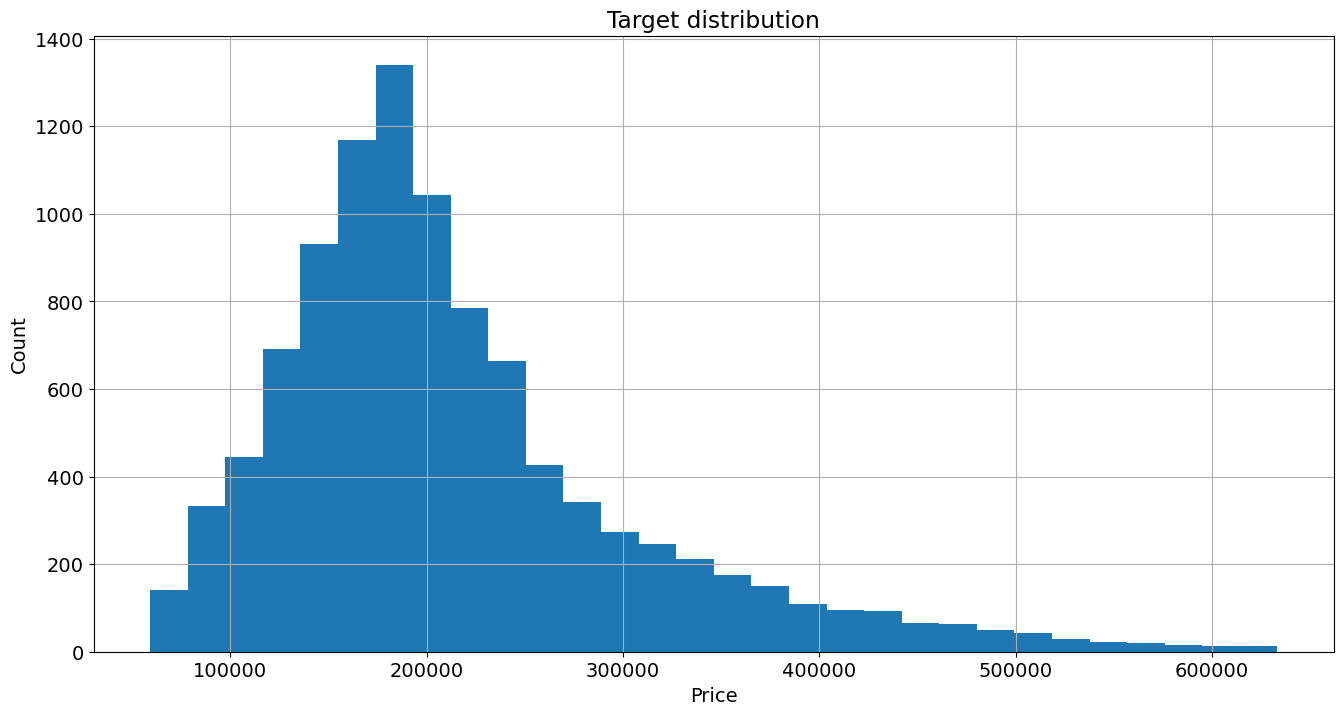

In [47]:
import numpy as np
import pandas as pd

import pickle
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size':14})

#не загружались датасеты напрямую - пришлось прописывать путь к файлу
test_df = pd.read_csv('C://Users//Светлана//Desktop/HomeWorkLibraries//test.csv')
test_df.tail()
train_df = pd.read_csv('C://Users//Светлана//Desktop/HomeWorkLibraries//train (1).csv')
train_df.tail()

plt.figure(figsize = (16, 8))
train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')

#обработка пропусков и выбросов
#через создание класса обработать не получилось. хоть убейся
X = train_df # переименовала для сокращения 
X.drop('Healthcare_1', axis=1, inplace=True)# удалили столбец с большим количеством необъяснимых пропусков

X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
X.loc[condition, 'LifeSquare'] = X.loc[condition,'Square'] - X.loc[condition,'KitchenSquare']#посчитали пропущенную жилую площадь

X.loc[X['HouseYear'] > 2020,'HouseYear'] = 2020 #заменили выброс года на 2020

X['HouseFloor_outlier'] = 0
X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1 #пропущенный этаж поставили как 1


X.loc[X['KitchenSquare'] < 3,'KitchenSquare' ] = X['KitchenSquare'].median()# площадь кухни меньше 3 заменили на среднюю


X['Rooms_outlier'] = 0
X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6),'Rooms_outlier' ] = 1
X.loc[X['Rooms'] == 0, 'Rooms'] = 1#отсутствие комнат заменили на однокомнатную
X.loc[X['Rooms'] >= 6, 'Rooms'] = X['Rooms'].median()# количество комнат больше 6 заменили на среднее

floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
X.loc[floor_outliers, 'HouseFloor'] = X.loc[floor_outliers,'Floor']#этаж выше этажности дома запишем как этажностть дома

X.tail()

#создание новых признаков

binary_to_numbers = {'A' : 0, 'B' : 1}
X['Ecology_2'] = X['Ecology_2'].replace(binary_to_numbers)
X['Ecology_3'] = X['Ecology_3'].replace(binary_to_numbers)
X['Shops_2'] = X['Shops_2'].replace(binary_to_numbers)

district_size = X['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 'DistrictId':'DistrictSize'})

X = X.merge(district_size, on='DistrictId', how='left')
X['IsDistrictLarge'] = (X['DistrictSize']>100).astype(int)
med_price_by_district = X.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})
X = X.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how="left")
X.head()
X.columns.tolist()
feature_names = ['Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear',
 'Ecology_1','Ecology_2','Ecology_3','Social_1','Social_2','Social_3','Helthcare_2','Shops_1','Shops_2']
new_feature_names = ['LifeSquare_nan','HouseFloor_outlier','Rooms_outlier','DistrictSize','IsDistrictLarge']
target_name =['Price']
bag_name = ['MedPriceByDistrict'] #повторила за преподавателем создание признака
train_df = X
train_df.head()

X = train_df.drop(columns=target_name)
X = train_df.drop(columns=bag_name)#пришлось исключить его.не давал сработать на тесте из-за отсутствия признака "прайс"
y = train_df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True,  random_state=42)
X_train.shape, X_valid.shape
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]

X_train.isna().sum().sum(), X_valid.isna().sum().sum()

model = RandomForestRegressor(criterion='squared_error',
                             max_depth=12,
                             random_state=42,
                             n_estimators=1000
                             )
model.fit(X_train, y_train.values[:, 0])
y_test_preds = model.predict(X_valid)
y_train_preds = model.predict(X_train)

r2(y_valid, y_test_preds)

r2(y_train, y_train_preds)
Train_R2 = r2(y_train, y_train_preds)
Test_R2 = r2(y_valid, y_test_preds)
print(Train_R2, Test_R2)

In [33]:
test_df = pd.read_csv('C://Users//Светлана//Desktop/HomeWorkLibraries//test.csv')
Z = test_df
#проведем трансформацию аналогично тренировочному тесту
#только признак средняя цена по району создать невозможно
Z.drop('Healthcare_1', axis=1, inplace=True)# удалили столбец с большим количеством необъяснимых пропусков

Z['LifeSquare_nan'] = Z['LifeSquare'].isna() * 1
condition = (Z['LifeSquare'].isna()) & (~Z['Square'].isna()) & (~Z['KitchenSquare'].isna())
Z.loc[condition, 'LifeSquare'] = Z.loc[condition,'Square'] - Z.loc[condition,'KitchenSquare']#посчитали пропущенную жилую площадь

Z.loc[Z['HouseYear'] > 2020,'HouseYear'] = 2020 #заменили выброс года на 2020

Z['HouseFloor_outlier'] = 0
Z.loc[Z['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
Z.loc[Z['Floor'] > Z['HouseFloor'], 'HouseFloor_outlier'] = 1 #пропущенный этаж поставили как 1


Z.loc[Z['KitchenSquare'] < 3,'KitchenSquare' ] = Z['KitchenSquare'].median()# площадь кухни меньше 3 заменили на среднюю


Z['Rooms_outlier'] = 0
Z.loc[(Z['Rooms'] == 0) | (Z['Rooms'] >= 6),'Rooms_outlier' ] = 1
Z.loc[Z['Rooms'] == 0, 'Rooms'] = 1#отсутствие комнат заменили на однокомнатную
Z.loc[Z['Rooms'] >= 6, 'Rooms'] = Z['Rooms'].median()# количество комнат больше 6 заменили на среднее

floor_outliers = Z.loc[Z['Floor'] > Z['HouseFloor']].index
Z.loc[floor_outliers, 'HouseFloor'] = Z.loc[floor_outliers,'Floor']#этаж выше этажности дома запишем как этажностть дома
binary_to_numbers = {'A' : 0, 'B' : 1}
Z['Ecology_2'] = Z['Ecology_2'].replace(binary_to_numbers)
Z['Ecology_3'] = Z['Ecology_3'].replace(binary_to_numbers)
Z['Shops_2'] = Z['Shops_2'].replace(binary_to_numbers)

district_size = Z['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 'DistrictId':'DistrictSize'})

Z = Z.merge(district_size, on='DistrictId', how='left')
Z['IsDistrictLarge'] = (X['DistrictSize']>100).astype(int)
Z.tail()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,HouseFloor_outlier,Rooms_outlier,DistrictSize,IsDistrictLarge
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,...,5992,0,1,1,1,0,0,0,45,0
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,...,264,0,0,1,1,0,0,0,344,0
4997,5783,12,3.0,77.842178,48.282625,9.0,23,23.0,1989,0.090799,...,19083,2,5,15,1,0,1,0,36,1
4998,4780,62,2.0,81.305222,81.305222,6.0,4,4.0,1977,0.072158,...,629,1,0,0,0,1,1,0,122,0
4999,12504,30,2.0,60.555693,59.555693,6.0,10,17.0,1977,0.000078,...,6398,141,3,23,1,1,0,0,115,1


In [48]:
Z = Z[feature_names + new_feature_names]
prediction = model.predict(Z)
with open('prediction', 'wb') as file:
    pickle.dump(prediction, file)
filename = 'Projekt_prediction.csv'
fields = ['price']
dict = {'price' : prediction}
df = pd.DataFrame(dict)
print(df) 

              price
0     187570.832573
1     232600.706196
2     210212.111558
3     374791.535503
4     138296.027344
...             ...
4995  247927.778822
4996  129674.902273
4997  342337.483490
4998  220254.506887
4999  504291.112416

[5000 rows x 1 columns]


In [50]:
prediction_1 = y_test_preds
with open('prediction_1', 'wb') as file:
    pickle.dump(prediction_1, file)
filename = 'Projekt_prediction_1.csv'
fields = ['price']
dict= {'price' : prediction_1}
df_1= pd.DataFrame(dict)
print(df_1) 

              price
0     187008.646550
1     279653.202934
2     214526.116190
3      69287.554874
4     129536.210585
...             ...
3295  323224.735739
3296  214019.939305
3297  244037.451569
3298  180924.892856
3299  192366.430269

[3300 rows x 1 columns]


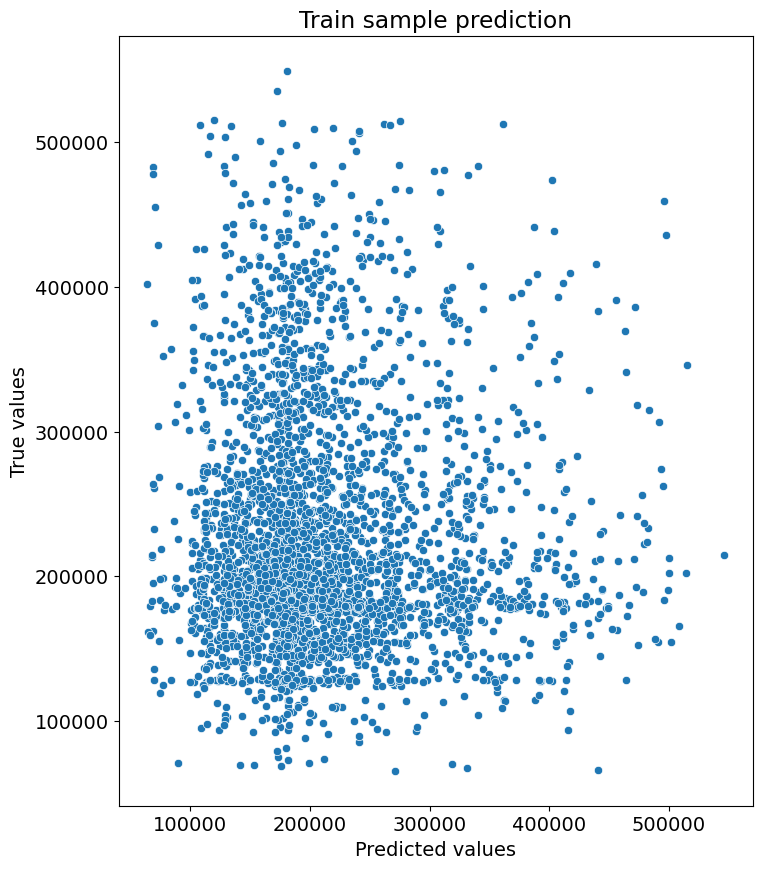

In [51]:
r = df.values[:, 0]
t = r[:3300]
p = df_1.values[:, 0]

plt.figure(figsize=(18,10))
plt.subplot(121)


sns.scatterplot(x=p, y=t)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Train sample prediction')
plt.show()